# Data Ingestion

## Copy CSV files to S3

In [1]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


no stored variable or alias setup_instance_check_passed
no stored variable or alias setup_dependencies_passed
no stored variable or alias setup_s3_bucket_passed
no stored variable or alias setup_iam_roles_passed


In [2]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"

# Destination Data:

s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"


                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-west-2-471112815505/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-west-2-471112815505/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-west-2-471112815505/ADS508_project/nyt/nyt-comments-2020.csv


## Create Database, Tables and Parquets
### Database

In [4]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [5]:
# Create Database
database_name = "dbpoliticpulsecomment"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


/tmp/ipykernel_28126/419283915.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)
/tmp/ipykernel_28126/419283915.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,dbpoliticpulsecomment
1,default
2,dsoaws


In [6]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [7]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


/tmp/ipykernel_28126/1858324476.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [8]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_28126/1253481606.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,2020-10-21 00:00:01.553481849


In [9]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


/tmp/ipykernel_28126/1775205595.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [10]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_28126/2201015668.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [11]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_28126/1150646089.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


### Parquets

In [12]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT 
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
WHERE
    tweet IS NOT NULL or tweet NOT LIKE '%.0' or LENGTH(tweet) > 0
UNION ALL
SELECT 
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
WHERE commentbody is NOT NULL or LENGTH(commentbody) > 0 
or commentid is NOT NULL
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

/tmp/ipykernel_28126/1968163504.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


,rows


In [13]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_28126/253224117.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,105821296.0,Joe Biden should use the 2013 troll tweet in e...,31792401,Richard,Illinois,2020-03-14 20:59:38,0,0,nyt_comment,0,1,Biden
1,105748008.0,Joe Biden had on his side the one thing that B...,78343265,KMW,New York City,2020-03-11 14:58:17,0,0,nyt_comment,0,2,Biden
2,105748840.0,Joe Biden will be fine as long as he has his w...,78343265,KMW,New York City,2020-03-11 15:20:06,2,19,nyt_comment,0,1,Biden
3,109320808.0,Joe Biden just needs to be himself (comfortabl...,63221581,tippicanoe,Los Angeles,2020-09-27 03:07:51,2,45,nyt_comment,0,2,Biden
4,108146432.0,Joe Biden has already released his. Next?,77933259,Patricia,Washington (the State),2020-07-15 18:07:29,0,9,nyt_comment,0,1,Biden


In [14]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [15]:
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT comment_id,
         user_name,
         user_location,
         comment_body,
         reply_retweet,
         recommendation_like,
         source,
         trump_count,
         biden_count,
         candidatepoll
FROM {}.{}
where candidatepoll is not null""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)


/tmp/ipykernel_28126/13945494.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


,rows


In [16]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_28126/2260227216.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


""


In [17]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

/tmp/ipykernel_28126/680368856.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_partitions = pd.read_sql(statement, conn)


,partition
0,candidatepoll=Trump
1,candidatepoll=Biden
2,candidatepoll=__HIVE_DEFAULT_PARTITION__


In [18]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

/tmp/ipykernel_28126/2954009692.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_partitions = pd.read_sql(statement, conn)


,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [19]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    WHERE candidatepoll = '{}' LIMIT 100""".format(
    database_name, table_parquet, candidatepoll
)
df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_28126/3427862730.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.321440e+18,beshannonphotos 🇺🇸,Northern Virginia,@jilevin And what will be done? #nothing sinc...,0.0,1.0,tweet,1,0,Trump
1,1.321440e+18,None,None,"""#Trump campaign website defaced by scammers",NaN,NaN,tweet,1,0,Trump
2,1.321440e+18,None,None,"""#Trump's going down and he knows it",NaN,NaN,tweet,1,0,Trump
3,1.321440e+18,None,None,"""@briantylercohen PERFECT Metaphor for Trump's...",NaN,NaN,tweet,1,0,Trump
4,1.321440e+18,Coach,,@atrupar Perfect metaphor of the fate these su...,0.0,0.0,tweet,1,0,Trump


## Query Data

In [20]:
# Setup and check pre-requisites to create Database

!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [21]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [22]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results_trump = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

df_parquet_results_trump.shape

(3017766, 4)

In [23]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""Twitter just outplayed #Trump",tweet,<NA>,Trump
1,Donald Trump'tan açıklama: Oylarımızı çalmaya ...,tweet,KABLO38,Trump
2,"""🇺🇸 [ALERTE] - #Twitter restreint le partage d...",tweet,Partout,Trump
3,Die First Lady der #USA: Pennsylvania #Trump #...,tweet,Munich,Trump
4,The most corrupted people #republicanparty #M...,tweet,,Trump


In [24]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results_biden = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

df_parquet_results_biden.shape


(1467774, 4)

In [25]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,"""@JoeBiden I'm proud to be a hispanic American",tweet,"""I'm a Lawyer committed to protect freedom of",Biden
1,#Poles #DonaldTrump #BidenHarrisToSaveAmerica2...,tweet,,Biden
2,@LisanneChristel When #Biden wins you also the...,tweet,<NA>,Biden
3,"""Aggiornamento. Vero il vantaggio di @JoeBiden",tweet,communication,Biden
4,"""I support Biden! WBU?",tweet,<NA>,Biden


# Data Exploration

In [26]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017766 entries, 0 to 3017765
Data columns (total 4 columns):
 #   Column         Dtype   
---  ------         -----   
 0   comment_body   string  
 1   source         string  
 2   user_location  string  
 3   candidatepoll  category
dtypes: category(1), string(3)
memory usage: 71.9 MB


In [27]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467774 entries, 0 to 1467773
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   comment_body   1467774 non-null  string  
 1   source         1467774 non-null  string  
 2   user_location  995943 non-null   string  
 3   candidatepoll  1467774 non-null  category
dtypes: category(1), string(3)
memory usage: 35.0 MB


In [28]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


source
tweet          1815135
nyt_comment    1202631
Name: count, dtype: Int64

In [29]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

source
tweet          1277964
nyt_comment     189810
Name: count, dtype: Int64

In [30]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

user_location
                        207132
NYC                      41439
California               36198
New York                 34941
USA                      26271
                         ...  
2009-06-05 22:02:34          3
2018-08-15 22:28:02          3
36640869.0                   3
9.71164596802384e+17         3
6025.0                       3
Name: count, Length: 96099, dtype: Int64

In [31]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

user_location
                 207132
NYC               41439
California        36198
New York          34941
USA               26271
Chicago           21186
NY                20535
Los Angeles       20400
San Francisco     19143
Seattle           18441
Florida           17367
United States     17235
NJ                16809
Boston            16245
New Jersey        13206
Canada            12930
New York City     12840
Colorado          11583
Brooklyn          11388
Texas             11322
CA                10701
Philadelphia       9801
Oregon             8508
Massachusetts      8502
Virginia           8298
Atlanta            8274
San Diego          7731
NC                 7341
Maryland           7302
Midwest            7098
Name: count, dtype: Int64

In [32]:
df_parquet_results_biden['user_location'].value_counts()

user_location
                                             156762
United States                                 10971
New York                                       7659
NYC                                            7374
USA                                            7026
                                              ...  
Jefftrigg2                                        3
16437.0                                           3
"Occupied                                         3
3319.0                                            3
 Retired Math teacher. Biden Harris 2020"         3
Name: count, Length: 75165, dtype: Int64

In [33]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

user_location
                 156762
United States     10971
New York           7659
NYC                7374
USA                7026
California         5568
NY                 3990
"Los Angeles       3840
"New York          3807
Chicago            3489
Los Angeles        3330
San Francisco      3327
"California        3033
Florida            3030
Seattle            3012
Boston             2619
"Washington        2541
NJ                 2421
Texas              2334
Virginia           2301
"Florida           2220
Canada             2202
New York City      2193
New Jersey         2073
Brooklyn           1935
"London            1908
0.0                1824
CA                 1785
"Texas             1770
Philadelphia       1731
Name: count, dtype: Int64

# Create EDA Overview Data Visualization

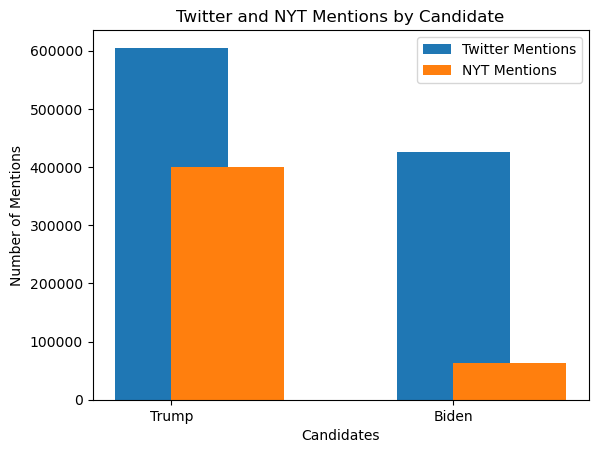

In [34]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [605045,425988]
nyt_n = [400877, 63270]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')
plt.show()


# Sentiment Labels Using Textblob

In [ ]:
# Code from ChatGPT
#!pip install textblob
from textblob import TextBlob

def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity

# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']


In [ ]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Trump

In [ ]:
# Examine Trump Sentiment distribution
df_parquet_results_trump['sentiment'].value_counts()

In [ ]:
# look at sample of tweets for each outcome
df_parquet_results_trump[df_parquet_results_trump['sentiment'] < 0].head(5)

In [ ]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] == 0].head(5)

In [ ]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] > 0].head(5)

In [ ]:
plt.hist(df_parquet_results_trump['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')
plt.show()

## Biden

In [ ]:
# Examine Biden Sentiment distribution
df_parquet_results_biden['sentiment'].value_counts()

In [ ]:
# look at sample of tweets for each outcome
df_parquet_results_biden[df_parquet_results_biden['sentiment'] < 0].head(5)

In [ ]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] == 0].head(5)

In [ ]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] > 0].head(5)

In [ ]:
plt.hist(df_parquet_results_biden['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')
plt.show()

# Data Bias

## Prepare Dataset for Bias Analysis

In [ ]:
# Combine df parquet for Trump and Biden
df = pd.concat([df_parquet_results_trump, df_parquet_results_biden], ignore_index=True, sort=False)


In [ ]:
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'negative' if x < 0 else ('neutral' if x == 0 else 'positive'))
df.head(5)

In [ ]:
# Balance the Dataset by candidate and Sentiment score
df_grouped_by = df.groupby(["candidatepoll", "sentiment_category"])[["candidatepoll", "sentiment_category"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

sns.countplot(data=df_balanced, x="sentiment_category", hue="candidatepoll")

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)